# Appendix (cont). - Modeling Code

In [1]:
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,  \
StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn import metrics, linear_model, tree
from sklearn.linear_model import BayesianRidge
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras import Model, Sequential

import pydotplus 
from IPython.display import Image

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, \
LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Enable Experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import warnings
warnings.filterwarnings("ignore")

In [2]:
coupons_df = pd.read_csv('https://archive.ics.uci.edu/ml/\
machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv')
coupons_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# Preprocessing


In [3]:
# define columns types
nom = ['destination', 'passenger', 'weather', 'coupon', 
       'gender', 'maritalStatus', 'occupation']
bin = ['gender', 'has_children', 'toCoupon_GEQ15min', 
       'toCoupon_GEQ25min', 'direction_same']
ord = ['temperature', 'age', 'education', 'income', 
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 
       'Restaurant20To50']
num = ['time', 'expiration']
ex = ['car', 'toCoupon_GEQ5min', 'direction_opp']

In [4]:
# Convert time to 24h military time
def convert_time(x):
    if x[-2:] == "AM":
        return int(x[0:-2]) % 12
    else:
        return (int(x[0:-2]) % 12) + 12

def average_income(x):
    inc = np.array(x).astype(np.float)
    return sum(inc) / len(inc)

def pre_process(df):
    # keep original dataframe imutable
    ret = df.copy()
    
    # Drop columns
    ret.drop(columns=['car', 'toCoupon_GEQ5min', 'direction_opp'], 
             inplace=True)

    # rename values
    ret = ret.rename(columns={'passanger':'passenger'})
    ret['time'] = ret['time'].apply(convert_time)
    ret['expiration'] = ret['expiration'].map({'1d':24, '2h':2})

    # convert the following columns to ordinal values
    ord_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 
                'Restaurant20To50']
    ret[ord_cols] = ret[ord_cols].replace({'never': 0, 'less1': 1, 
                                                 '1~3': 2, '4~8': 3, 'gt8': 4})
    
    # impute missing
    ret[ord_cols] = SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent').fit_transform(ret[ord_cols])
    
    # Changing coupon expiration to uniform # of hours
    ret['expiration'] = coupons_df['expiration'].map({'1d':24, '2h':2}) 

    # Age, Education, Income as ordinal
    ret['age'] = ret['age'].map({'below21':1, 
                                                 '21':2,'26':3,
                                                 '31':4,'36':5, 
                                                 '41':6,'46':6,
                                                 '50plus':7}) 
    ret['education'] = ret['education'].map(\
                            {'Some High School':1, 
                             'Some college - no degree':2, 
                             'Bachelors degree':3, 'Associates degree':4, 
                             'High School Graduate':5, 
                             'Graduate degree (Masters or Doctorate)':6})
    ret['average income'] = ret['income'].str.findall('(\d+)').apply(average_income)
    ret['income'].replace({'Less than $12500': 1, '$12500 - $24999': 2, 
                           '$25000 - $37499': 3, '$37500 - $49999': 4, 
                           '$50000 - $62499': 5, '$62500 - $74999': 6,
                           '$75000 - $87499': 7, '$87500 - $99999': 8,
                           '$100000 or More': 9}, inplace=True)

    # Change gender to binary value
    ret['gender'].replace({'Male': 0, 'Female': 1}, inplace=True)
    
    # One Hot Encode
    nom = ['destination', 'passenger', 'weather', 'coupon', 
           'maritalStatus', 'occupation']
    for col in nom:
        # k-1 cols from k values
        ohe_cols = pd.get_dummies(ret[col], prefix=col, drop_first=True)
        ret = pd.concat([ret, ohe_cols], axis=1)
        ret.drop(columns=[col], inplace=True)

    return ret 

In [5]:
# Simple function to prep a dataframe for a model
def scale_data(df, std, norm, pass_cols):
    """
    df: raw dataframe you want to process
    std: list of column names you want to standardize (0 mean unit variance)
    norm: list of column names you want to normalize (min-max)
    pass_cols: list of columns that do not require processing (target var, etc.)

    returns: prepped dataframe
    """
    ret = df.copy()
    # Only include columns from lists
    ret = ret[std + norm + pass_cols]
    # Standardize scaling for gaussian features
    if (isinstance(std, list)) and (len(std) > 0):
        ret[std] = StandardScaler().fit(ret[std]).transform(ret[std])
    # Normalize (min-max) [0,1] for non-gaussian features
    if (isinstance(norm, list)) and (len(norm) > 0):
        ret[norm] = Normalizer().fit(ret[norm]).transform(ret[norm])

    
    return ret

In [6]:
# Processed data (remove labels from dataset)
coupons_proc = pre_process(coupons_df.drop(columns='Y'))

# Labels
labels = coupons_df['Y']

# Standardize/Normalize
to_scale = ['average income', 'temperature', 'time', 'expiration']
coupons_proc = scale_data(coupons_proc, to_scale, [], 
list(set(coupons_proc.columns.tolist()).difference(set(to_scale))))

coupons_proc.head()

,average income,temperature,time,expiration,occupation_Computer & Mathematical,has_children,occupation_Sales & Related,occupation_Community & Social Services,CarryAway,destination_No Urgent Place,...,occupation_Farming Fishing & Forestry,income,Restaurant20To50,coupon_Coffee House,passenger_Partner,occupation_Healthcare Practitioners & Technical,toCoupon_GEQ25min,coupon_Carry out & Take away,occupation_Retired,occupation_Education&Training&Library
0,-0.299684,-0.433430,0.033233,0.888114,0,1,0,0,2.0,1,...,0,4,2.0,0,0,0,0,0,0,0
1,-0.299684,0.871799,-0.706285,-1.125982,0,1,0,0,2.0,1,...,0,4,2.0,1,0,0,0,0,0,0
2,-0.299684,0.871799,-0.706285,-1.125982,0,1,0,0,2.0,1,...,0,4,2.0,0,0,0,0,1,0,0
3,-0.299684,0.871799,0.033233,-1.125982,0,1,0,0,2.0,1,...,0,4,2.0,1,0,0,0,0,0,0
4,-0.299684,0.871799,0.033233,0.888114,0,1,0,0,2.0,1,...,0,4,2.0,1,0,0,0,0,0,0


**Train/Test Split**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(coupons_proc, labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

<br/>

______


<br/>

# Modeling

## Neural Network


In [8]:
# Suppress info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'}

# learning rates
alphas = [0.0001, 0.001, 0.01, 0.1]
nn_models = []
nn_train_preds = []
nn_test_preds = []

for alpha in alphas:
    nn_model = Sequential()
    # nn_model.add(InputLayer(input_shape=(X_train.shape[1],)))
    nn_model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
    nn_model.add(Dense(64, activation='relu'))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dense(16, activation='relu'))
    nn_model.add(Dense(8, activation='relu'))
    nn_model.add(Dense(4, activation='relu'))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha, 
                                                      beta_1=0.9, 
                                                      beta_2=0.999, 
                                                      epsilon=1e-07, 
                                                      amsgrad=False,
                                                      name='Adam')
                  , loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    # nn_model.summary()
    nn_model.fit(X_train.values, y_train.values, epochs=300, verbose=0)

    # Store model
    nn_models.append(nn_model)

    nn_train_preds.append(nn_model.predict(X_train))
    nn_test_preds.append(nn_model.predict(X_test))
  

100/100 [==============================] - 0s 795us/step


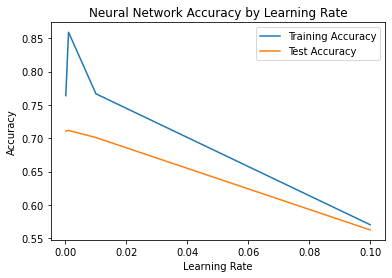

In [9]:
train_acc = [metrics.accuracy_score(y_train, (nn_train_preds[i] >= 0.5) \
                                    .astype(int)) for i in range(4)]
test_acc = [metrics.accuracy_score(y_test, (nn_test_preds[i] >= 0.5).\
                                   astype(int)) for i in range(4)]
sns.lineplot(x=alphas, y=train_acc, label='Training Accuracy')
sns.lineplot(x=alphas, y=test_acc, label='Test Accuracy')
plt.title('Neural Network Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

Based on the plot above, the optimal learning rate for the neural network os 0.001.

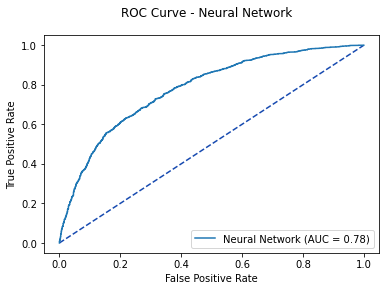

Optimal Threshold 0.649641


In [10]:
# Optimal Model predictions
nn_pred = nn_test_preds[1]

nn_roc = metrics.roc_curve(y_test, nn_pred)
nn_auc = metrics.auc(nn_roc[0], nn_roc[1])

# set true ositive rate, false positive rate, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, nn_pred)

# set the parameters for the ROC Curve
nn_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
                                  roc_auc=nn_auc,
                                  estimator_name='Neural Network')

# plot the ROC Curve
fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Neural Network')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
nn_plot.plot(ax)
plt.show()

# Optimal Threshold value
nn_opt = nn_roc[2][np.argmax(nn_roc[1] - nn_roc[0])]
print('Optimal Threshold %f' % nn_opt)

The optimized Neural Network predictions are further optimized based on the ROC Curve, defining the optimal probability threshold of 0.57

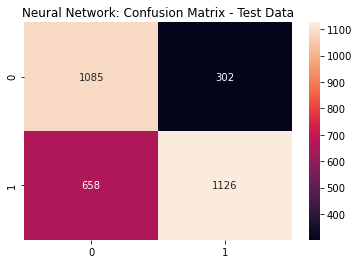

In [11]:
nn_cfm = metrics.confusion_matrix(y_test, (nn_pred >= nn_opt).astype(int))
sns.heatmap(nn_cfm, annot=True, fmt='g')
plt.title('Neural Network: Confusion Matrix - Test Data')
plt.show()

**Neural Network Metrics**

In [12]:
print(metrics.classification_report(y_test, 
     (nn_pred >= nn_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1387
           1       0.79      0.63      0.70      1784

    accuracy                           0.70      3171
   macro avg       0.71      0.71      0.70      3171
weighted avg       0.72      0.70      0.70      3171



## Linear Discriminant Analysis

In [13]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_cv = cross_val_score(lda_model, X_train, y_train)

In [14]:
print('LDA 5-fold Cross Validation Average %f' % lda_cv.mean())

LDA 5-fold Cross Validation Average 0.680229


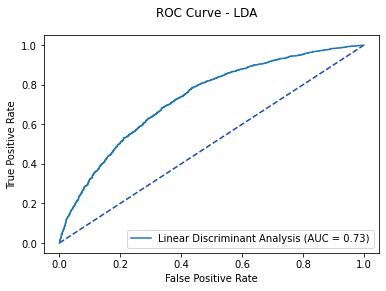

Optimal Threshold 0.496193


In [15]:
# extract predicted probabilities from the model
lda_pred = lda_model.predict_proba(X_test)[:, 1]

# gather metrics
lda_roc = metrics.roc_curve(y_test, lda_pred)
lda_auc = metrics.auc(lda_roc[0], lda_roc[1])

# determine false positive rate, true positive rate, threshold
fpr, tpr, thresholds = metrics.roc_curve(y_test, lda_pred)

# set up the plot
lda_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=lda_auc, estimator_name='Linear Discriminant Analysis')

# make the plot
fig, ax = plt.subplots()
fig.suptitle('ROC Curve - LDA')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
lda_plot.plot(ax)
plt.show()

# Optimal Threshold value
lda_opt = lda_roc[2][np.argmax(lda_roc[1] - lda_roc[0])]

print('Optimal Threshold %f' % lda_opt)

Based on the ROC Curve the optimal probability threshold for the trained LDA model is 0.496

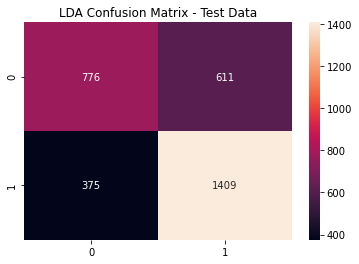

In [16]:
lda_cfm = metrics.confusion_matrix(y_test, (lda_pred >= lda_opt).astype(int))
sns.heatmap(lda_cfm, annot=True, fmt='g')
plt.title('LDA Confusion Matrix - Test Data')
plt.show()

**LDA Metrics**

In [17]:
print(metrics.classification_report(y_test, 
     (lda_pred >= lda_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      1387
           1       0.70      0.79      0.74      1784

    accuracy                           0.69      3171
   macro avg       0.69      0.67      0.68      3171
weighted avg       0.69      0.69      0.68      3171



## Quadratic Discriminant Analysis

In [18]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_cv = cross_val_score(qda_model, X_train, y_train)

In [19]:
print('QDA 5-fold Cross Validation Average %f' % qda_cv.mean())

QDA 5-fold Cross Validation Average 0.664881


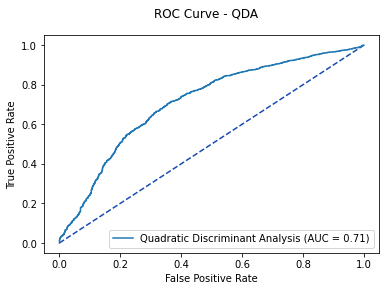

Optimal Threshold 0.462775


In [20]:
qda_pred = qda_model.predict_proba(X_test)[:, 1]

qda_roc = metrics.roc_curve(y_test, qda_pred)
qda_auc = metrics.auc(qda_roc[0], qda_roc[1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, qda_pred)

qda_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=qda_auc, estimator_name='Quadratic Discriminant Analysis')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - QDA')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
qda_plot.plot(ax)
plt.show()

# Optimal Threshold value
qda_opt = qda_roc[2][np.argmax(qda_roc[1] - qda_roc[0])]

print('Optimal Threshold %f' % qda_opt)

Based on the ROC Curve, the QDA Model has an optimal probability threshold of 0.463

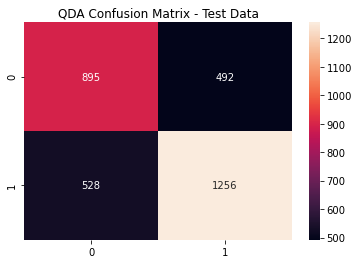

In [21]:
qda_cfm = metrics.confusion_matrix(y_test, 
                                   (qda_pred >= qda_opt).astype(int))
sns.heatmap(qda_cfm, 
            annot=True, fmt='g')

plt.title('QDA Confusion Matrix - Test Data')
plt.show()

**QDA Metrics**

In [22]:
print(metrics.classification_report(y_test, 
(qda_pred >= lda_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1387
           1       0.72      0.69      0.70      1784

    accuracy                           0.67      3171
   macro avg       0.67      0.67      0.67      3171
weighted avg       0.68      0.67      0.68      3171



## Gradient Boosting

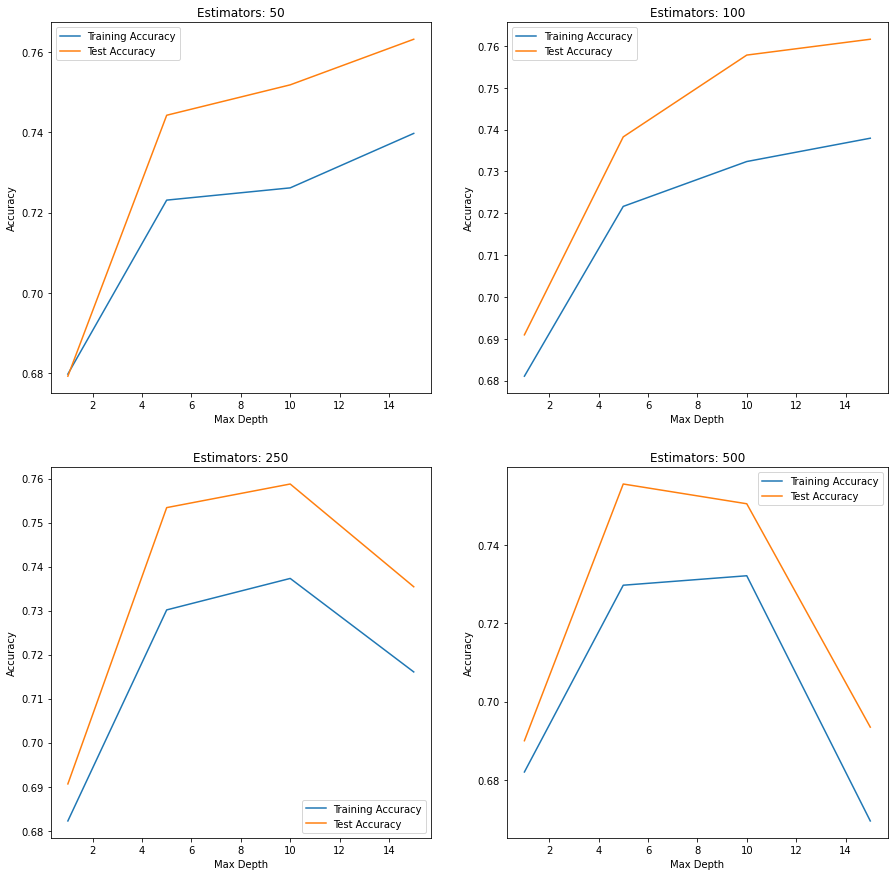

In [23]:
estimators = [50, 100, 250, 500]
depths = [1, 5, 10, 15]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes = ax.flatten()
k = 0
for i in estimators:

    train_scores = []
    test_scores = []
    for j in depths:
        gb_model = GradientBoostingClassifier(n_estimators=i, 
                                              learning_rate=1.0, 
                                              max_depth=j, 
                                              random_state=42).fit\
                                              (X_train, y_train)
        train_scores.append(cross_val_score(gb_model, X_train, y_train, 
                                            scoring='accuracy', 
                                            n_jobs=2).mean())
        test_scores.append(metrics.accuracy_score(y_test,
                                                  gb_model.predict(X_test)))
  
    sns.lineplot(x=depths, y=train_scores, label='Training Accuracy', 
                 ax=axes[k])
    sns.lineplot(x=depths, y=test_scores, label='Test Accuracy', ax=axes[k])
    axes[k].set_title('Estimators: %d' % i)
    axes[k].set_xlabel('Max Depth')
    axes[k].set_ylabel('Accuracy')
    k += 1    

Based on the plots above, the Gradient Boosting Model with 500 trees with a max depth of 15, scored the highest overall test data accuracy.

In [24]:
# Optimal parameters 500 estimators, max_depth = 15
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, 
                                          max_depth=15, 
                                          random_state=42).fit(X_train, y_train)

In [25]:
gb_pred = gb_model.predict_proba(X_test)[:, 1]

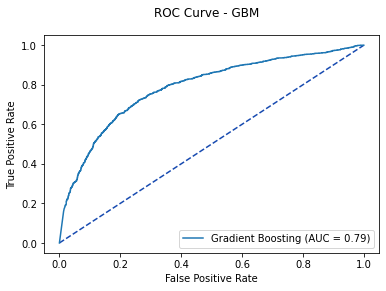

In [26]:
gb_roc = metrics.roc_curve(y_test, gb_pred)
gb_auc = metrics.auc(gb_roc[0], gb_roc[1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, gb_pred)
gb_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=gb_auc, 
                                  estimator_name='Gradient Boosting')
fig, ax = plt.subplots()
fig.suptitle('ROC Curve - GBM')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
gb_plot.plot(ax)
plt.show()

# Optimal Threshold value
gb_opt = gb_roc[2][np.argmax(gb_roc[1] - gb_roc[0])]

# print('Optimal Threshold %f' % gb_opt)

Based on the ROC Curve, the Gradient Boosting Model's optimal probability threshold is 0.361

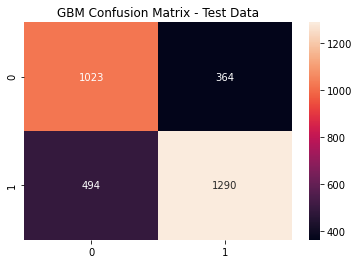

In [27]:
gb_cfm = metrics.confusion_matrix(y_test, (gb_pred >= gb_opt).astype(int))
sns.heatmap(gb_cfm, annot=True, fmt='g')
plt.title('GBM Confusion Matrix - Test Data')
plt.show()

**GBM Metrics**

In [28]:
print(metrics.classification_report(y_test, (gb_pred >= gb_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1387
           1       0.78      0.72      0.75      1784

    accuracy                           0.73      3171
   macro avg       0.73      0.73      0.73      3171
weighted avg       0.73      0.73      0.73      3171



## *K*-Nearest Neighbors

We look to *K* - nearest neighbors to determine the conditional probability $Pr$ that a given target $Y$ belongs to a class label $j$ given that our feature space $X$ is a matrix of observations $x_o$.

We sum the *k*-nearest observations contained in a set $\mathcal{N}_0$ over an indicator variable $I$,thereby giving us a result of 0 or 1, dependent on class $j$.

$$Pr(Y=j|X=x_0)=\frac{1}{k}\large \sum_{i\in \mathcal{N}_0} \normalsize I(y_i=j)$$

### Euclidean Distance

Euclidean distance is used to measure the space between our input data and other data points in our feature space:

$$ d(x,y) = \sqrt{\large \sum_{\normalsize {i=1}}^{\normalsize {p}}\normalsize(x_i - y_i)^2} $$

# of Neighbors = 1 	 Testing Accuracy = 0.65 	         Training Accuracy = 1.00
# of Neighbors = 3 	 Testing Accuracy = 0.66 	         Training Accuracy = 0.82
# of Neighbors = 5 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.78
# of Neighbors = 7 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.76
# of Neighbors = 9 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.75
# of Neighbors = 11 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.74
# of Neighbors = 13 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.74
# of Neighbors = 15 	 Testing Accuracy = 0.66 	         Training Accuracy = 0.73
# of Neighbors = 17 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.73
# of Neighbors = 19 	 Testing Accuracy = 0.67 	         Training Accuracy = 0.73


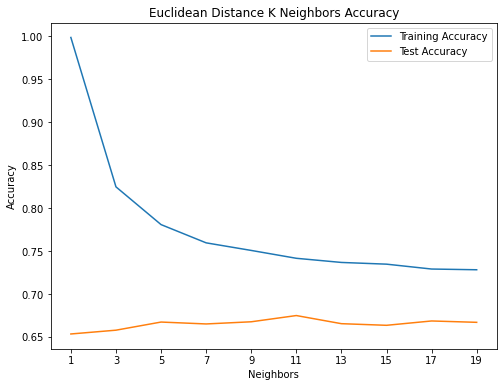

In [29]:
# euclidean distance
knn_train_accuracy = []
knn_test_accuracy = []

for n in range(1, 20) :
    
    if(n%2!=0):
        knn = KNeighborsClassifier(n_neighbors = n, p = 2)
        knn = knn.fit(X_train,y_train)
        knn_pred_train = knn.predict(X_train)
        knn_pred_test = knn.predict(X_test)
        knn_train_accuracy.append(accuracy_score(y_train, knn_pred_train))
        knn_test_accuracy.append(accuracy_score(y_test, knn_pred_test))
        print('# of Neighbors = %d \t Testing Accuracy = %2.2f \t \
        Training Accuracy = %2.2f'% (n, accuracy_score(y_test,knn_pred_test),
                               accuracy_score(y_train,knn_pred_train)))
    
max_depth = list([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
plt.figure(figsize=(8,6)) 
plt.plot(max_depth, knn_train_accuracy, label='Training Accuracy')
plt.plot(max_depth, knn_test_accuracy, label='Test Accuracy')
plt.title('Euclidean Distance K Neighbors Accuracy')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

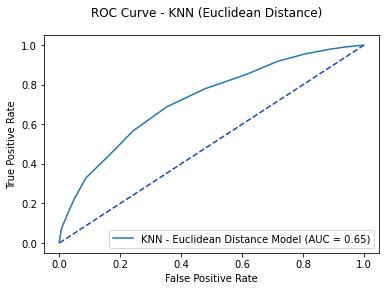

Optimal Threshold 1.000000


In [30]:
knn_pred = knn.predict_proba(X_test)[:, 1]

knn_roc = metrics.roc_curve(y_test, knn_pred_test)
knn_auc = metrics.auc(knn_roc[0], knn_roc[1])

fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred)

knn_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
roc_auc=knn_auc, estimator_name='KNN - Euclidean Distance Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - KNN (Euclidean Distance)')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
knn_plot.plot(ax)
plt.show()

# Optimal Threshold value
knn_opt = knn_roc[2][np.argmax(knn_roc[1] - knn_roc[0])]

print('Optimal Threshold %f' % knn_opt)

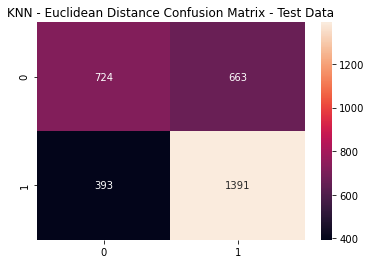

In [31]:
metrics.accuracy_score(y_test, (knn_pred_test >= knn_opt).astype(int))
knn_cfm = metrics.confusion_matrix(y_test, (knn_pred_test >= knn_opt).astype(int))
sns.heatmap(knn_cfm, annot=True, fmt='g')
plt.title('KNN - Euclidean Distance Confusion Matrix - Test Data')
plt.show()

**KNN: Euclidean Distance Metrics**

In [32]:
print(metrics.classification_report(y_test, 
(knn_pred_test >= knn_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.65      0.52      0.58      1387
           1       0.68      0.78      0.72      1784

    accuracy                           0.67      3171
   macro avg       0.66      0.65      0.65      3171
weighted avg       0.66      0.67      0.66      3171



## KNN - Manhattan Distance

$$ d(x,y) = \large \sum_{\normalsize i=1} ^n |x_i - y_i| $$

# of Neighbors = 1 	 Testing Accuracy 0.66 	     Training Accuracy 1.00
# of Neighbors = 5 	 Testing Accuracy 0.67 	     Training Accuracy 0.79
# of Neighbors = 11 	 Testing Accuracy 0.67 	     Training Accuracy 0.74
# of Neighbors = 15 	 Testing Accuracy 0.67 	     Training Accuracy 0.74
# of Neighbors = 21 	 Testing Accuracy 0.68 	     Training Accuracy 0.73
# of Neighbors = 25 	 Testing Accuracy 0.69 	     Training Accuracy 0.73
# of Neighbors = 31 	 Testing Accuracy 0.69 	     Training Accuracy 0.73


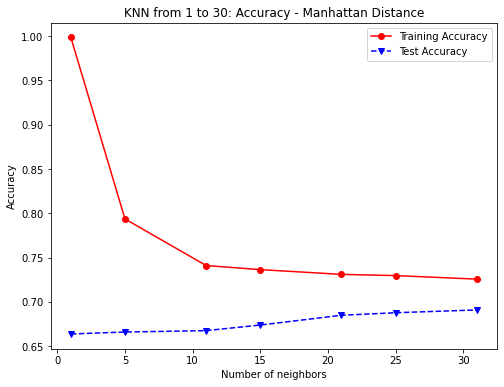

In [33]:
# k-nearest neighbor - KNN Manhattan Distance
numNeighbors = [1, 5, 11, 15, 21, 25, 31]
knn1_train_accuracy = []
knn1_test_accuracy = []

for k in numNeighbors:
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan', p=1)
    knn1.fit(X_train, y_train)
    knn1_pred_train = knn1.predict(X_train)
    knn1_pred_test = knn1.predict(X_test)
    knn1_train_accuracy.append(accuracy_score(y_train, knn1_pred_train))
    knn1_test_accuracy.append(accuracy_score(y_test, knn1_pred_test))
    print('# of Neighbors = %d \t Testing Accuracy %2.2f \t \
    Training Accuracy %2.2f'% (k,accuracy_score(y_test,knn1_pred_test),
                               accuracy_score(y_train,knn1_pred_train)))

plt.figure(figsize=(8,6))
plt.plot(numNeighbors, knn1_train_accuracy, 'ro-', 
         numNeighbors, knn1_test_accuracy,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.title('KNN from 1 to 30: Accuracy - Manhattan Distance')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

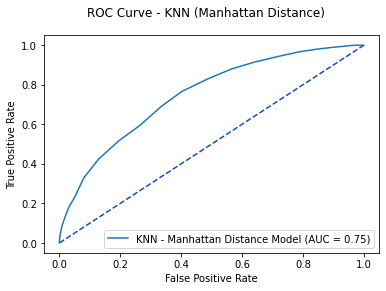

Optimal Threshold 0.548387


In [34]:
knn_pred1 = knn1.predict_proba(X_test)[:, 1]

knn1_roc = metrics.roc_curve(y_test, knn_pred1)
knn1_auc = metrics.auc(knn1_roc[0], knn1_roc[1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred1)
knn1_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=knn1_auc, 
            estimator_name='KNN - Manhattan Distance Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - KNN (Manhattan Distance)')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
knn1_plot.plot(ax)
plt.show()

# Optimal Threshold value
knn1_opt = knn1_roc[2][np.argmax(knn1_roc[1] - knn1_roc[0])]

print('Optimal Threshold %f' % knn1_opt)

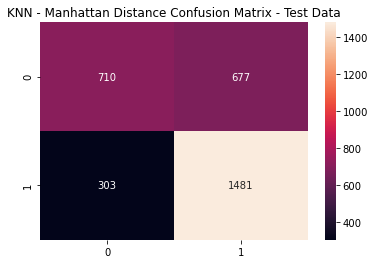

In [35]:
metrics.accuracy_score(y_test, (knn1_pred_test >= knn1_opt).astype(int))
knn1_cfm = metrics.confusion_matrix(y_test, (knn1_pred_test >= knn1_opt).astype(int))
sns.heatmap(knn1_cfm, annot=True, fmt='g')
plt.title('KNN - Manhattan Distance Confusion Matrix - Test Data')
plt.show()

**KNN: Manhattan Distance Metrics**

In [36]:
print(metrics.classification_report(y_test, 
(knn1_pred_test >= knn1_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59      1387
           1       0.69      0.83      0.75      1784

    accuracy                           0.69      3171
   macro avg       0.69      0.67      0.67      3171
weighted avg       0.69      0.69      0.68      3171



## Random Forest Model

Max Depth =  1 	 Testing Accuracy = 0.56 	     Training Accuracy = 0.57
Max Depth =  2 	 Testing Accuracy = 0.59 	     Training Accuracy = 0.59
Max Depth =  3 	 Testing Accuracy = 0.64 	     Training Accuracy = 0.64
Max Depth =  4 	 Testing Accuracy = 0.66 	     Training Accuracy = 0.67
Max Depth =  5 	 Testing Accuracy = 0.68 	     Training Accuracy = 0.69
Max Depth =  6 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.71
Max Depth =  7 	 Testing Accuracy = 0.70 	     Training Accuracy = 0.73
Max Depth =  8 	 Testing Accuracy = 0.71 	     Training Accuracy = 0.75
Max Depth =  9 	 Testing Accuracy = 0.71 	     Training Accuracy = 0.78
Max Depth = 10 	 Testing Accuracy = 0.71 	     Training Accuracy = 0.81
Max Depth = 11 	 Testing Accuracy = 0.72 	     Training Accuracy = 0.85
Max Depth = 12 	 Testing Accuracy = 0.72 	     Training Accuracy = 0.88
Max Depth = 13 	 Testing Accuracy = 0.74 	     Training Accuracy = 0.91
Max Depth = 14 	 Testing Accuracy = 0.73 	     Training Accuracy

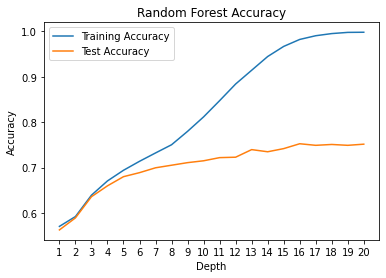

In [37]:
rf_train_accuracy = []
rf_test_accuracy = []
for n in range(1, 21):
    rf = RandomForestClassifier(max_depth = n, random_state=42)
    rf = rf.fit(X_train,y_train)
    rf_pred_train = rf.predict(X_train)
    rf_pred_test = rf.predict(X_test)
    rf_train_accuracy.append(accuracy_score(y_train, rf_pred_train))
    rf_test_accuracy.append(accuracy_score(y_test, rf_pred_test))
    print('Max Depth = %2.0f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (n,accuracy_score(y_test,rf_pred_test),
                               accuracy_score(y_train,rf_pred_train)))
max_depth = list(range(1,21))
plt.plot(max_depth, rf_train_accuracy, label='Training Accuracy')
plt.plot(max_depth, rf_test_accuracy, label='Test Accuracy')
plt.title('Random Forest Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth); plt.legend(); plt.show()

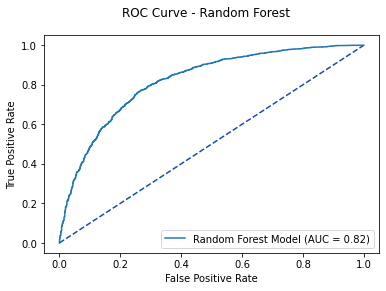

Optimal Threshold 0.560204


In [38]:
rf_model = RandomForestClassifier(max_depth = 16, 
                                  random_state = 42)
rf_model = rf_model.fit(X_train,y_train)
rf_model_pred_test = rf_model.predict(X_test)
rf_pred1 = rf.predict_proba(X_test)[:, 1]
rf_roc = metrics.roc_curve(y_test, rf_pred1)
rf_auc = metrics.auc(rf_roc[0], rf_roc[1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred1)
rf_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=rf_auc, estimator_name='Random Forest Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Random Forest')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
rf_plot.plot(ax)
plt.show()
# Optimal Threshold value
rf_opt = rf_roc[2][np.argmax(rf_roc[1] - rf_roc[0])]
print('Optimal Threshold %f' % rf_opt)

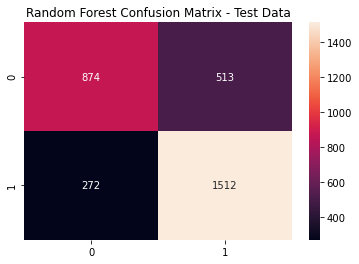

In [39]:
metrics.accuracy_score(y_test, (rf_model_pred_test >= rf_opt).astype(int))
rf_cfm = metrics.confusion_matrix(y_test, (rf_model_pred_test >= rf_opt).astype(int))
sns.heatmap(rf_cfm, annot=True, fmt='g')
plt.title('Random Forest Confusion Matrix - Test Data'); plt.show()

**Random Forest Metrics**

In [40]:
print(metrics.classification_report(y_test, 
                                    (rf_model_pred_test >= rf_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      1387
           1       0.75      0.85      0.79      1784

    accuracy                           0.75      3171
   macro avg       0.75      0.74      0.74      3171
weighted avg       0.75      0.75      0.75      3171



## Naive Bayes

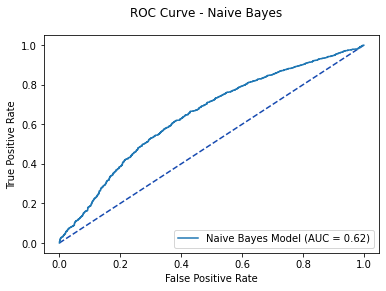

Optimal Threshold 1.000000


In [41]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

nb_model_pred_test = nb_model.predict(X_test)
nb_pred1 = nb_model.predict_proba(X_test)[:, 1]

nb_roc = metrics.roc_curve(y_test, 
                           nb_model_pred_test)

nb_auc = metrics.auc(nb_roc[0], nb_roc[1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                         nb_pred1)

nb_plot = metrics.RocCurveDisplay(fpr=fpr, 
                                  tpr=tpr,
                                  roc_auc=nb_auc, 
                                  estimator_name='Naive Bayes Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Naive Bayes')
plt.plot([0, 1], 
         [0, 1], 
         linestyle = '--', 
         color = '#174ab0')

nb_plot.plot(ax)
plt.show()

# Optimal Threshold value
nb_opt = nb_roc[2][np.argmax(nb_roc[1] - nb_roc[0])]

print('Optimal Threshold %f' % nb_opt)

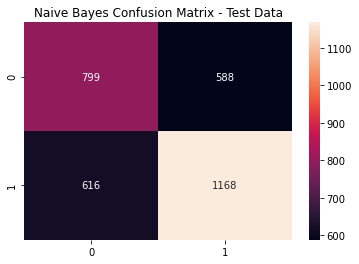

In [42]:
metrics.accuracy_score(y_test, (nb_model_pred_test >= nb_opt).astype(int))
nb_cfm = metrics.confusion_matrix(y_test, (nb_model_pred_test >= nb_opt).astype(int))
sns.heatmap(nb_cfm, annot=True, fmt='g')
plt.title('Naive Bayes Confusion Matrix - Test Data')
plt.show()

**Naive Bayes Metrics**

In [43]:
print(metrics.classification_report(y_test, 
                                    (nb_model_pred_test >= nb_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1387
           1       0.67      0.65      0.66      1784

    accuracy                           0.62      3171
   macro avg       0.61      0.62      0.62      3171
weighted avg       0.62      0.62      0.62      3171



## Tuned Decision Tree Classifier

In [44]:
coupon_tree2 = tree.DecisionTreeClassifier(max_depth=3, 
                                           max_features=56,
                                           random_state=42)

coupon_tree2 = coupon_tree2.fit(X_train,y_train)

coupon_pred2 = coupon_tree2.predict(X_test)
print('accuracy = %2.2f ' % accuracy_score(y_test,
                                           coupon_pred2))

accuracy = 0.66 


In [45]:
print(classification_report(y_test, coupon_pred2))

              precision    recall  f1-score   support

           0       0.65      0.48      0.55      1387
           1       0.66      0.80      0.73      1784

    accuracy                           0.66      3171
   macro avg       0.66      0.64      0.64      3171
weighted avg       0.66      0.66      0.65      3171



### Plotting the Decision Tree

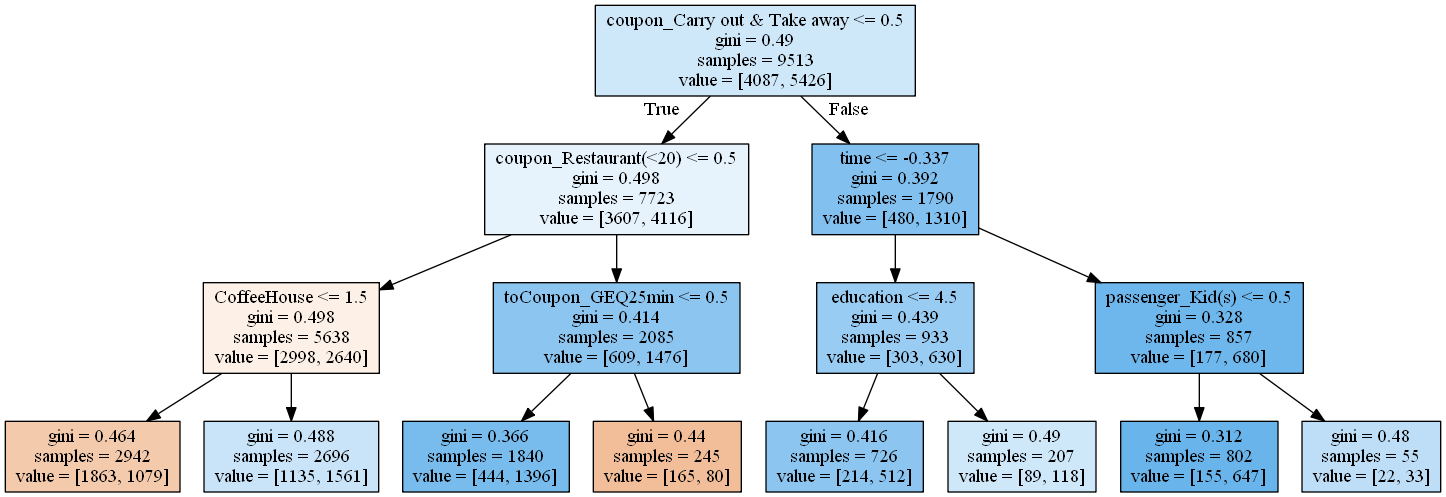

In [46]:
dot_data = tree.export_graphviz(coupon_tree2, 
                                feature_names=coupons_proc.columns, 
                                filled=True, 
                                out_file=None) 

graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

### Decision Tree Tuning (Varying Max-Depth from 3 to 10)

Depth =  3 	 Testing Accuracy = 0.66 	     Training Accuracy = 0.66
Depth =  4 	 Testing Accuracy = 0.68 	     Training Accuracy = 0.67
Depth =  5 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Depth =  6 	 Testing Accuracy = 0.70 	     Training Accuracy = 0.70
Depth =  7 	 Testing Accuracy = 0.70 	     Training Accuracy = 0.72
Depth =  8 	 Testing Accuracy = 0.70 	     Training Accuracy = 0.74
Depth =  9 	 Testing Accuracy = 0.71 	     Training Accuracy = 0.76
Depth = 10 	 Testing Accuracy = 0.70 	     Training Accuracy = 0.79


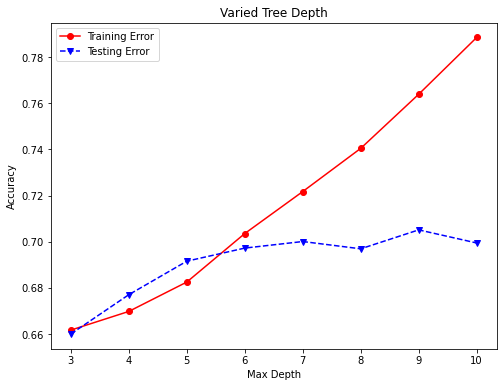

In [47]:
accuracy_depth = []

# Vary the decision tree depth in a loop, increasing depth from 3 to 10. 
for depth in range(3,11):
    varied_tree  = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    varied_tree  = varied_tree.fit(X_train,y_train)
    tree_pred = varied_tree.predict(X_test)
    tree_train_pred = varied_tree.predict(X_train)
    accuracy_depth.append({'depth':depth,
                           'test_accuracy':accuracy_score(y_test,tree_pred),
                           'train_accuracy':accuracy_score(y_train,tree_train_pred)})
    print('Depth = %2.0f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (depth,accuracy_score(y_test,tree_pred),
                               accuracy_score(y_train,tree_train_pred)))

abd_df = pd.DataFrame(accuracy_depth)
abd_df.index = abd_df['depth']

fig, ax=plt.subplots(figsize=(8,6))

ax.plot(abd_df.depth,abd_df.train_accuracy,'ro-',label='Training Error')
ax.plot(abd_df.depth,abd_df.test_accuracy,'bv--',label='Testing Error')
plt.title('Varied Tree Depth')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

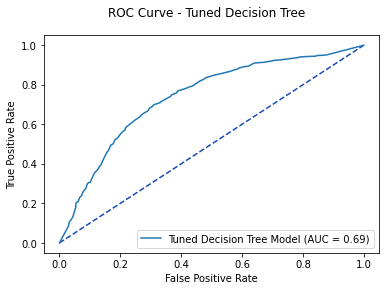

Optimal Threshold 1.000000


In [48]:
varied_tree_roc = metrics.roc_curve(y_test, tree_pred)
varied_tree_auc = metrics.auc(varied_tree_roc[0], varied_tree_roc[1])
varied_tree1 = varied_tree.predict_proba(X_test)[: ,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, varied_tree1)
varied_tree_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
roc_auc = varied_tree_auc, 
          estimator_name='Tuned Decision Tree Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Tuned Decision Tree')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
varied_tree_plot.plot(ax)
plt.show()

# Optimal Threshold value
varied_tree_opt = varied_tree_roc[2][np.argmax(
    varied_tree_roc[1]-varied_tree_roc[0])]

print('Optimal Threshold %f' % varied_tree_opt)

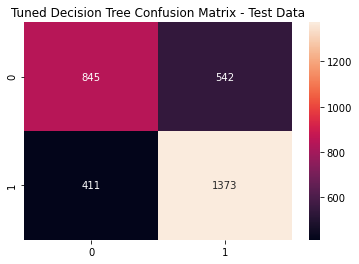

In [49]:
metrics.accuracy_score(y_test, (tree_pred >= varied_tree_opt).astype(int))
tlr_cfm = metrics.confusion_matrix(y_test, (tree_pred >= varied_tree_opt).astype(int))
sns.heatmap(tlr_cfm, annot=True, fmt='g')
plt.title('Tuned Decision Tree Confusion Matrix - Test Data')
plt.show()

**Tuned Decision Tree Metrics**

In [50]:
print(metrics.classification_report(y_test, (tree_pred >= varied_tree_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1387
           1       0.72      0.77      0.74      1784

    accuracy                           0.70      3171
   macro avg       0.69      0.69      0.69      3171
weighted avg       0.70      0.70      0.70      3171



## Tuned Logistic Regression Model

We hereby tune our logistic regression model as follows. Using a linear classifier, the model is able to create a linearly separable hyperplane bounded by the class of observations from our preprocessed coupon dataset and the likelihood of occurrences within the class. 

The descriptive form of the ensuing logistic regression is shown below:
\begin{equation*}
P(y=1|x) = \frac{1}{1 + \exp^{-w^Tx - b}} = \sigma(w^Tx + b)
\end{equation*}

The model is further broken down into an optimization function of the regularized negative log-likelihood, where w and b are estimated parameters. 

\begin{equation*}
(w^*,b^*) = \arg\min_{w,b} - \sum_{i=1}^N y_i \log\bigg[\sigma(w^Tx_i + b)\bigg] + (1-y_i) \log\bigg[\sigma(-w^Tx_i - b)\bigg] + \frac{1}{C} \Omega([w,b])
\end{equation*}

Herein, we further tune our cost hyperparamter $C$, such that the model complexity is varied $($regularized by $\Omega(\cdot))$ from smallest to largest, producing a greater propensity for classification accuracy at each iteration. 

Moreover, we rely on the default $l_2$-norm to pair with the lbfgs solver, and cap off our max iterations at 2,000 such that the model does not fail to converge.

Cost = 0.01 	 Testing Accuracy = 0.67 	     Training Accuracy = 0.67
Cost = 0.10 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 0.20 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 0.50 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 0.80 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 1.00 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 5.00 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.68
Cost = 10.00 	 Testing Accuracy = 0.68 	     Training Accuracy = 0.68
Cost = 20.00 	 Testing Accuracy = 0.68 	     Training Accuracy = 0.68
Cost = 50.00 	 Testing Accuracy = 0.68 	     Training Accuracy = 0.68


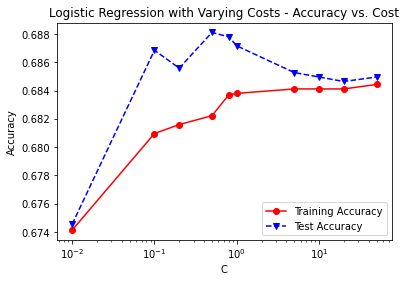

In [51]:
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRtestAcc = []

for param in C:
    tlr = linear_model.LogisticRegression(penalty='l2', 
                                          solver = 'lbfgs',
                                          max_iter= 2000,
                                          C=param, random_state=42)
    tlr.fit(X_train, y_train)
    tlr_pred_train = tlr.predict(X_train)
    tlr_pred_test = tlr.predict(X_test)
    LRtrainAcc.append(accuracy_score(y_train, tlr_pred_train))
    LRtestAcc.append(accuracy_score(y_test, tlr_pred_test))
    print('Cost = %2.2f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param,accuracy_score(y_test,tlr_pred_test),
                               accuracy_score(y_train,tlr_pred_train)))
    
fig, ax = plt.subplots()
ax.plot(C, LRtrainAcc, 'ro-', C, LRtestAcc,'bv--')
ax.legend(['Training Accuracy','Test Accuracy'])
plt.title('Logistic Regression with Varying Costs - Accuracy vs. Cost')
ax.set_xlabel('C')
ax.set_xscale('log')
ax.set_ylabel('Accuracy')
plt.show()

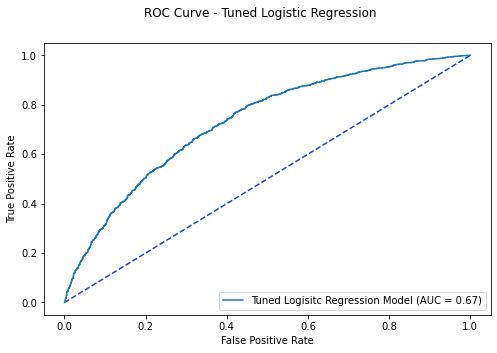

Optimal Threshold 1.000000


In [52]:
tlr_roc = metrics.roc_curve(y_test, tlr_pred_test)
tlr_auc = metrics.auc(tlr_roc[0], tlr_roc[1])
tlr1 = tlr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, tlr1)
tlr_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
roc_auc=tlr_auc, estimator_name='Tuned Logisitc Regression Model')

fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle('ROC Curve - Tuned Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
tlr_plot.plot(ax)
plt.show()

# Optimal Threshold value
tlr_opt = tlr_roc[2][np.argmax(tlr_roc[1] - tlr_roc[0])]

print('Optimal Threshold %f' % tlr_opt)

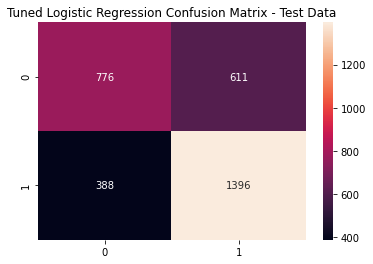

In [53]:
metrics.accuracy_score(y_test, (tlr_pred_test >= tlr_opt).astype(int))
tlr_cfm = metrics.confusion_matrix(y_test, (tlr_pred_test >= tlr_opt).astype(int))
sns.heatmap(tlr_cfm, annot=True, fmt='g')
plt.title('Tuned Logistic Regression Confusion Matrix - Test Data')
plt.show()

**Tuned Logistic Regression Metrics**

In [54]:
print(metrics.classification_report(y_test, (tlr_pred_test >= tlr_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      1387
           1       0.70      0.78      0.74      1784

    accuracy                           0.68      3171
   macro avg       0.68      0.67      0.67      3171
weighted avg       0.68      0.68      0.68      3171



## Support Vector Machines

Similar to that of logistic regression, a linear support vector machine model relies on estimating $(w^*,b^*)$ visa vie constrained optimization of the following form:
\begin{eqnarray*}
&&\min_{w^*,b^*,\{\xi_i\}} \frac{\|w\|^2}{2} + \frac{1}{C} \sum_i \xi_i \\
\textrm{s.t.} && \forall i: y_i\bigg[w^T \phi(x_i) + b\bigg] \ge 1 - \xi_i, \ \ \xi_i \ge 0  
\end{eqnarray*}

However, our endeavor relies on the radial basis function kernel:

$$ K(x,x^{'}) = \text{exp} \left(-\frac{||x-x^{'}||^2}{2\sigma^2} \right) $$

where $ ||x-x^{'}||^2 $ is the squared Euclidean distance between the two feature vectors, and $\gamma = \frac{1}{2\sigma^2}$. 

Simplifying the equation we have:

$$ K(x,x^{'}) = \text{exp} (-\gamma ||x-x^{'}||^2) $$

## SVM (Radial Basis Function) Model

### Untuned Support Vector Machine

In [55]:
svm1 = SVC(kernel='rbf', random_state=42)
svm1.fit(X_train, y_train)
svm1_pred_test = svm1.predict(X_test)
print('accuracy = %2.2f ' % accuracy_score(y_test, svm1_pred_test))

accuracy = 0.71 


### Setting (tuning) the gamma hyperparameter to "auto"

In [56]:
svm2 = SVC(kernel='rbf', gamma='auto', random_state=42)
svm2.fit(X_train, y_train)
svm2_pred_test = svm2.predict(X_test)
print('accuracy = %2.2f ' % accuracy_score(svm2_pred_test,y_test))

accuracy = 0.72 


### Tuning the support vector machine over 10 values of the cost hyperparameter

Cost = 0.01 	 Testing Accuracy = 0.56 	     Training Accuracy = 0.57
Cost = 0.10 	 Testing Accuracy = 0.67 	     Training Accuracy = 0.68
Cost = 0.20 	 Testing Accuracy = 0.69 	     Training Accuracy = 0.70
Cost = 0.50 	 Testing Accuracy = 0.71 	     Training Accuracy = 0.72
Cost = 0.80 	 Testing Accuracy = 0.72 	     Training Accuracy = 0.74
Cost = 1.00 	 Testing Accuracy = 0.72 	     Training Accuracy = 0.74
Cost = 5.00 	 Testing Accuracy = 0.74 	     Training Accuracy = 0.78
Cost = 10.00 	 Testing Accuracy = 0.75 	     Training Accuracy = 0.81
Cost = 20.00 	 Testing Accuracy = 0.76 	     Training Accuracy = 0.84
Cost = 50.00 	 Testing Accuracy = 0.76 	     Training Accuracy = 0.87


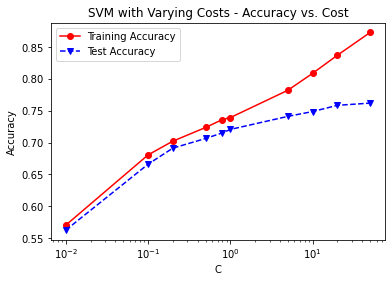

In [57]:
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
svm3_trainAcc = []
svm3_testAcc = []

for param in C:
    svm3 = SVC(C=param,kernel='rbf', gamma = 'auto', random_state=42, 
               probability=True)
    svm3.fit(X_train, y_train)
    svm3_pred_train = svm3.predict(X_train)
    svm3_pred_test = svm3.predict(X_test)
    svm3_trainAcc.append(accuracy_score(y_train, svm3_pred_train))
    svm3_testAcc.append(accuracy_score(y_test, svm3_pred_test))
    print('Cost = %2.2f \t Testing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param,accuracy_score(y_test,svm3_pred_test),
                               accuracy_score(y_train,svm3_pred_train)))    

fig, ax = plt.subplots()
ax.plot(C, svm3_trainAcc, 'ro-', C, svm3_testAcc,'bv--')
ax.legend(['Training Accuracy','Test Accuracy'])
plt.title('SVM with Varying Costs - Accuracy vs. Cost')
ax.set_xlabel('C')
ax.set_xscale('log')
ax.set_ylabel('Accuracy')
plt.show()

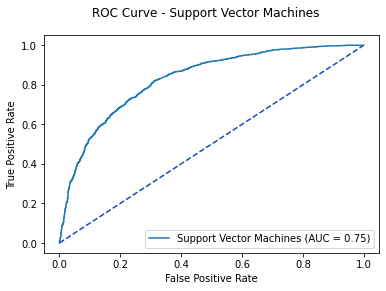

Optimal Threshold 1.000000


In [58]:
svm3_roc = metrics.roc_curve(y_test, svm3_pred_test)
svm3_auc = metrics.auc(svm3_roc[0], svm3_roc[1])
svm3_pred = svm3.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, svm3_pred)
svm3_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
roc_auc=svm3_auc, estimator_name='Support Vector Machines')
fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Support Vector Machines')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
svm3_plot.plot(ax)
plt.show()

# Optimal Threshold value
svm3_opt = svm3_roc[2][np.argmax(svm3_roc[1] - svm3_roc[0])]
print('Optimal Threshold %f' % svm3_opt)

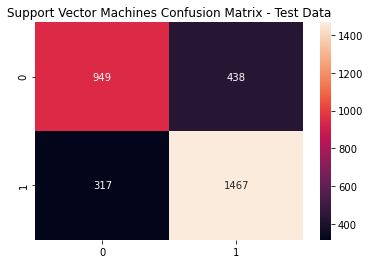

In [59]:
metrics.accuracy_score(y_test, (svm3_pred_test >= svm3_opt).astype(int))
svm3_cfm = metrics.confusion_matrix(y_test, (svm3_pred_test >= svm3_opt).astype(int))
sns.heatmap(svm3_cfm, annot=True, fmt='g')
plt.title('Support Vector Machines Confusion Matrix - Test Data'); plt.show()

In [60]:
print(metrics.classification_report(y_test,
                                    (svm3_pred_test >= svm3_opt).astype(int)))

              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1387
           1       0.77      0.82      0.80      1784

    accuracy                           0.76      3171
   macro avg       0.76      0.75      0.76      3171
weighted avg       0.76      0.76      0.76      3171



# Combined ROC Curves

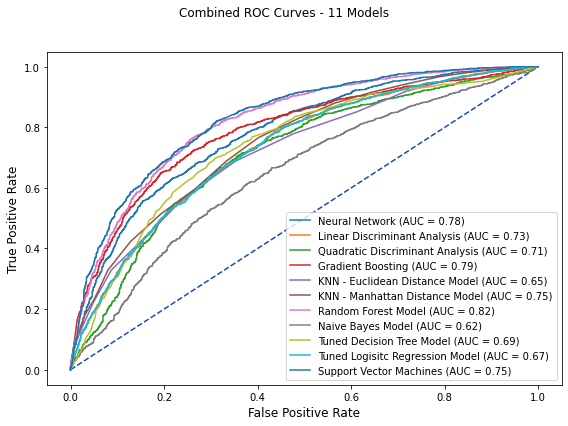

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Combined ROC Curves - 11 Models')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.xlabel('',fontsize=12) 
plt.ylabel('',fontsize=12) 

# Model ROC Plots Defined above
# neural network
nn_plot.plot(ax)
# linear discriminant analysis
lda_plot.plot(ax) 
# quadratic discriminant analysis
qda_plot.plot(ax) 
# gradient boosting 
gb_plot.plot(ax) 
# k-nearest neighbors euclidean distance
knn_plot.plot(ax) 
# k-nearest neighbors manhattan distance
knn1_plot.plot(ax) 
# random forest
rf_plot.plot(ax)
# naive bayes
nb_plot.plot(ax)
# tuned decision tree
varied_tree_plot.plot(ax) 
# tuned logistic regression
tlr_plot.plot(ax) 
# support vector machines
svm3_plot.plot(ax) 

# set the plotting margins 
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()